In [2]:
import pandas as pd
import numpy as np
import io
import sagemaker.amazon.common as smac
from pandas import DataFrame
import boto3
from sagemaker import get_execution_role
import sagemaker
from sagemaker import KMeans
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
role = get_execution_role()
bucket='i3-bucket'
sub_folder = 'movies_dataset'


In [4]:
data_key = 'movies.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
movies = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')
movies_save = movies
movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
data_key = 'ratings.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
ratings = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')
ratings


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
ratingsCount = len(ratings)
moviesCount = len(movies)
usersCount = len(ratings['userId'].value_counts())
print('This dataset contains', ratingsCount, 'ratings of', moviesCount, 'movies by', usersCount, 'users.')

This dataset contains 100836 ratings of 9742 movies by 610 users.


In [7]:
ratings = ratings.drop(['timestamp'], axis=1)
ratings['UserRatingCount'] = ratings.groupby('userId')['userId'].transform('count')
ratings

,userId,movieId,rating,UserRatingCount
0,1,1,4.0,232
1,1,3,4.0,232
2,1,6,4.0,232
3,1,47,5.0,232
4,1,50,5.0,232
...,...,...,...,...
100831,610,166534,4.0,1302
100832,610,168248,5.0,1302
100833,610,168250,5.0,1302
100834,610,168252,5.0,1302


In [8]:
movies.genres

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9742, dtype: object

In [9]:
movies['genres'] = movies.genres.str.split('|')
movies['genres']

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [10]:
df = movies
x = []
for index, row in movies.iterrows():
    x.append(index)
    for genre in row['genres']:
        df.at[index, genre] = 1

In [11]:
movies = movies.fillna(0)
movies = movies.drop(['genres','IMAX', 'Western','Film-Noir', 'Animation','Children','War','Musical','Documentary'], axis=1)
movies

,movieId,title,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
0,1,Toy Story (1995),1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,No Game No Life: Zero (2017),0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,Flint (2017),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df = pd.merge(ratings, movies, on='movieId')
df = df.sort_values('userId')
df

,userId,movieId,rating,UserRatingCount,title,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
0,1,1,4.0,232,Toy Story (1995),1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,Psycho (1998),0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
12126,1,2395,5.0,232,Rushmore (1998),0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,Romancing the Stone (1984),1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,From Dusk Till Dawn (1996),0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,"Host, The (Gwoemul) (2006)",0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
26937,610,589,5.0,1302,Terminator 2: Judgment Day (1991),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
69808,610,66097,4.0,1302,Coraline (2009),0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,"Serious Man, A (2009)",0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


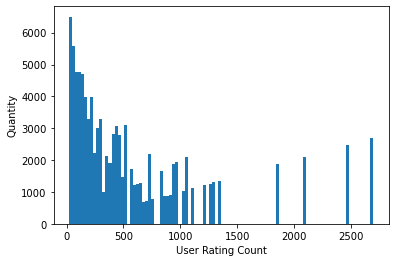

In [14]:
x = df['UserRatingCount']
n_bins = 100
plt.hist(x, bins=n_bins)
plt.xlabel('User Rating Count')
plt.ylabel('Quantity')
plt.show()


In [15]:
df[df['UserRatingCount'] == 20 ]['userId'].value_counts()


442    20
431    20
406    20
320    20
278    20
257    20
207    20
194    20
189    20
147    20
595    20
576    20
569    20
53     20
Name: userId, dtype: int64

In [16]:
df[df['UserRatingCount'] >= 1500]['userId'].value_counts()


414    2698
599    2478
474    2108
448    1864
Name: userId, dtype: int64

In [17]:
df.drop(df[df['UserRatingCount'] >= 1500].index, inplace = True)


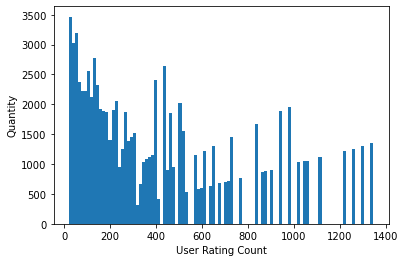

In [18]:
x = df['UserRatingCount']
n_bins = 100
plt.hist(x, bins=n_bins)
plt.xlabel('User Rating Count')
plt.ylabel('Quantity')
plt.show()

In [19]:
# df.loc[:,['Adventure',
#  'Animation',
#  'Children',
#  'Comedy',
#  'Fantasy',
#  'Romance',
#  'Drama',
#  'Action',
#  'Crime',
#  'Thriller',
#  'Horror',
#  'Mystery',
#  'Sci-Fi',
#  'War',
#  'Musical',
#  'Documentary',
#  'IMAX',
#  'Western',
#  'Film-Noir',
#  '(no genres listed)']] = df.loc[:,['Adventure',
#  'Animation',
#  'Children',
#  'Comedy',
#  'Fantasy',
#  'Romance',
#  'Drama',
#  'Action',
#  'Crime',
#  'Thriller',
#  'Horror',
#  'Mystery',
#  'Sci-Fi',
#  'War',
#  'Musical',
#  'Documentary',
#  'IMAX',
#  'Western',
#  'Film-Noir',
#  '(no genres listed)']].multiply(df.loc[:, 'rating'], axis="index")

df.loc[:,['Adventure',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 '(no genres listed)']] = df.loc[:,['Adventure',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 '(no genres listed)']].multiply(df.loc[:, 'rating'], axis="index")
df


,userId,movieId,rating,UserRatingCount,title,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
0,1,1,4.0,232,Toy Story (1995),4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,Psycho (1998),0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0
12126,1,2395,5.0,232,Rushmore (1998),0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,Romancing the Stone (1984),4.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,From Dusk Till Dawn (1996),0.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,"Host, The (Gwoemul) (2006)",0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0
26937,610,589,5.0,1302,Terminator 2: Judgment Day (1991),0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0
69808,610,66097,4.0,1302,Coraline (2009),0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,"Serious Man, A (2009)",0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df.loc[:,['Adventure',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 '(no genres listed)']] = df.loc[:,['Adventure',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 '(no genres listed)']].divide(df.loc[:, 'UserRatingCount'], axis="index")
df

,userId,movieId,rating,UserRatingCount,title,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
0,1,1,4.0,232,Toy Story (1995),0.017241,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0
12117,1,2389,2.0,232,Psycho (1998),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008621,0.008621,0.008621,0.0,0.00000,0.0
12126,1,2395,5.0,232,Rushmore (1998),0.000000,0.021552,0.000000,0.000000,0.021552,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0
12182,1,2406,4.0,232,Romancing the Stone (1984),0.017241,0.017241,0.000000,0.017241,0.000000,0.017241,0.000000,0.000000,0.000000,0.0,0.00000,0.0
776,1,70,3.0,232,From Dusk Till Dawn (1996),0.000000,0.012931,0.000000,0.000000,0.000000,0.012931,0.000000,0.012931,0.012931,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,"Host, The (Gwoemul) (2006)",0.000000,0.003840,0.000000,0.000000,0.003840,0.000000,0.000000,0.003840,0.003840,0.0,0.00384,0.0
26937,610,589,5.0,1302,Terminator 2: Judgment Day (1991),0.000000,0.000000,0.000000,0.000000,0.000000,0.003840,0.000000,0.000000,0.000000,0.0,0.00384,0.0
69808,610,66097,4.0,1302,Coraline (2009),0.000000,0.000000,0.003072,0.000000,0.000000,0.000000,0.000000,0.003072,0.000000,0.0,0.00000,0.0
69820,610,71464,4.0,1302,"Serious Man, A (2009)",0.000000,0.003072,0.000000,0.000000,0.003072,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0


In [21]:
df = df.groupby(['userId'], as_index=False)['Adventure',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 '(no genres listed)'].sum()
df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,userId,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
0,1,1.607759,1.530172,0.870690,0.482759,1.327586,1.676724,0.844828,0.982759,0.254310,0.323276,0.728448,0.0
1,2,0.431034,0.965517,0.000000,0.155172,2.275862,1.500000,1.310345,1.275862,0.103448,0.275862,0.534483,0.0
2,3,0.769231,0.230769,0.346154,0.064103,0.307692,1.282051,0.025641,0.743590,0.961538,0.128205,1.615385,0.0
3,4,0.490741,1.689815,0.324074,0.907407,1.935185,0.384259,0.476852,0.625000,0.078704,0.370370,0.157407,0.0
4,5,0.590909,1.181818,0.659091,0.772727,2.159091,0.636364,1.045455,0.727273,0.068182,0.090909,0.113636,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,606,0.461883,1.346188,0.313004,1.191031,2.371300,0.430493,0.435874,0.629148,0.156054,0.309417,0.252018,0.0
602,607,0.834225,0.978610,0.401070,0.545455,1.759358,1.433155,0.550802,1.342246,0.770053,0.422460,0.625668,0.0
603,608,0.701564,1.169073,0.400722,0.368231,1.158243,1.110108,0.634777,1.102286,0.387485,0.294826,0.662455,0.0
604,609,0.864865,0.621622,0.081081,0.432432,1.729730,0.918919,0.567568,1.243243,0.189189,0.000000,0.405405,0.0


In [22]:
userId_mapping = pd.DataFrame(df, columns = ['userId'])


In [23]:
df = df.drop(['userId'], axis=1)


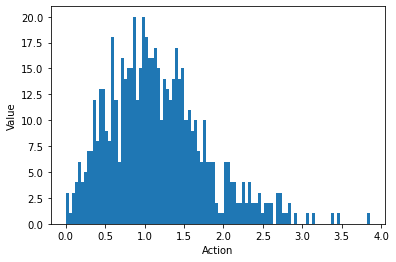

In [24]:
n_bins = 100
plt.hist(df['Action'], bins=n_bins)
plt.xlabel('Action')
plt.ylabel('Value')
plt.show()

<AxesSubplot:>

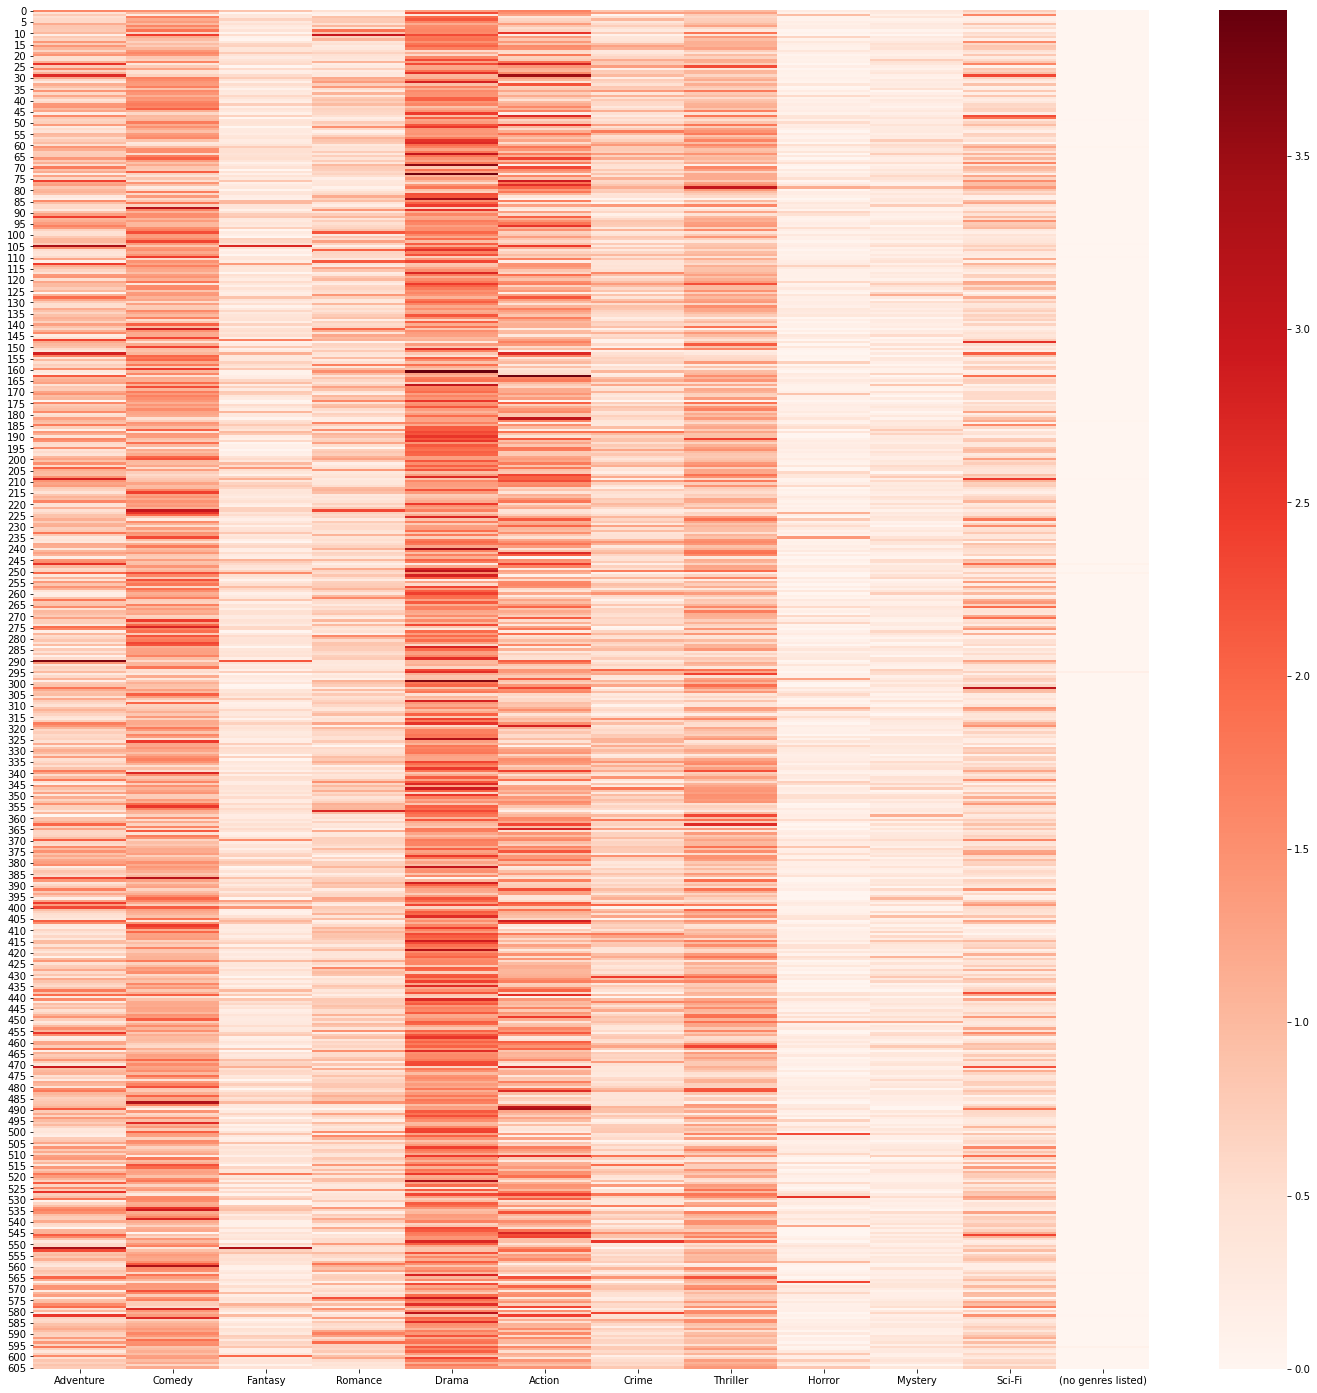

In [25]:
fig, ax1 = plt.subplots(figsize = (25, 25))
sns.heatmap(df, ax = ax1, cmap = 'Reds')

In [26]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns
df_scaled.index = df.index


In [27]:
df_scaled.describe()


,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,0.257251,0.379740,0.129136,0.227371,0.408242,0.301290,0.267316,0.337266,0.084826,0.244076,0.204029,0.007238
std,0.145536,0.158170,0.098418,0.131171,0.155554,0.161113,0.152049,0.151906,0.098939,0.158748,0.140064,0.057170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.159562,0.273267,0.069709,0.135203,0.301416,0.187546,0.167807,0.238356,0.033891,0.134186,0.106747,0.000000
50%,0.235969,0.362897,0.114286,0.203704,0.395450,0.282176,0.246758,0.328356,0.062512,0.228128,0.179335,0.000000
75%,0.327878,0.458843,0.163504,0.286311,0.512064,0.388489,0.337640,0.434180,0.103456,0.319070,0.263218,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
data_train = df_scaled
data_train = data_train.astype('float32')
num_clusters = 10
output_location = 's3://' + bucket + '/model-artifacts'

kmeans = KMeans(role=role,
               train_instance_count=1,
               train_instance_type='ml.c4.xlarge',
               output_path=output_location,
               k=num_clusters)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [29]:
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 605
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Adventure           606 non-null    float32
 1   Comedy              606 non-null    float32
 2   Fantasy             606 non-null    float32
 3   Romance             606 non-null    float32
 4   Drama               606 non-null    float32
 5   Action              606 non-null    float32
 6   Crime               606 non-null    float32
 7   Thriller            606 non-null    float32
 8   Horror              606 non-null    float32
 9   Mystery             606 non-null    float32
 10  Sci-Fi              606 non-null    float32
 11  (no genres listed)  606 non-null    float32
dtypes: float32(12)
memory usage: 33.1 KB


,Adventure,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,(no genres listed)
0,0.433396,0.460224,0.265353,0.160920,0.332711,0.434259,0.336310,0.324029,0.099116,0.271914,0.233280,0.0
1,0.116192,0.290395,0.000000,0.051724,0.576699,0.388489,0.521624,0.420669,0.040318,0.232034,0.171164,0.0
2,0.207358,0.069408,0.105495,0.021368,0.070296,0.332042,0.010207,0.245172,0.374753,0.107836,0.517313,0.0
3,0.132287,0.508239,0.098765,0.302469,0.489044,0.099520,0.189826,0.206071,0.030674,0.311526,0.050408,0.0
4,0.159289,0.355451,0.200866,0.257576,0.546654,0.164814,0.416176,0.239792,0.026573,0.076466,0.036391,0.0
5,0.157103,0.409962,0.089293,0.268577,0.405752,0.190533,0.145794,0.253061,0.076956,0.150009,0.074451,0.0
6,0.317449,0.306702,0.141353,0.174342,0.293282,0.355263,0.225230,0.319952,0.051282,0.246249,0.279158,0.0
7,0.223682,0.492745,0.084296,0.347518,0.385284,0.220419,0.296444,0.420911,0.074632,0.214754,0.088577,0.0
8,0.222684,0.359612,0.066253,0.137681,0.393852,0.140757,0.190387,0.200695,0.076254,0.219423,0.167083,0.0
9,0.213727,0.554269,0.127347,0.619048,0.408315,0.168345,0.115159,0.094204,0.009744,0.039052,0.022874,0.0


In [30]:
job_name = 'kmeans-recom-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

Here is the job name kmeans-recom-job-20220314233910


In [31]:
%%time
kmeans.fit(kmeans.record_set(data_train.values), job_name=job_name)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-14 23:39:11 Starting - Starting the training job...
2022-03-14 23:39:39 Starting - Preparing the instances for trainingProfilerReport-1647301151: InProgress
.........
2022-03-14 23:40:59 Downloading - Downloading input data.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2022 23:41:54 INFO 139792844236608 integration.py:636] worker started
[03/14/2022 23:41:54 INFO 139792844236608] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', '_num_gpus': 'au

In [ ]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

In [33]:
%%time 
result = kmeans_predictor.predict(data_train.values[0:len(data_train)])
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 49.2 ms, sys: 45 µs, total: 49.3 ms
Wall time: 226 ms


In [34]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [35]:
userId_mapping['Cluster Labels'] = cluster_labels


In [36]:
clusterNumber = 8


In [37]:
users_cluster = [i for i, j in enumerate(cluster_labels) if j == clusterNumber]
users_cluster = userId_mapping['userId'].iloc[users_cluster]

In [38]:
clust_movieRatings = ratings.loc[ratings['userId'].isin(users_cluster)]
clust_movieRatings

,userId,movieId,rating,UserRatingCount
0,1,1,4.0,232
1,1,3,4.0,232
2,1,6,4.0,232
3,1,47,5.0,232
4,1,50,5.0,232
...,...,...,...,...
100831,610,166534,4.0,1302
100832,610,168248,5.0,1302
100833,610,168250,5.0,1302
100834,610,168252,5.0,1302


In [39]:
clust_df_scaled = df_scaled.iloc[users_cluster.index, :]


<AxesSubplot:>

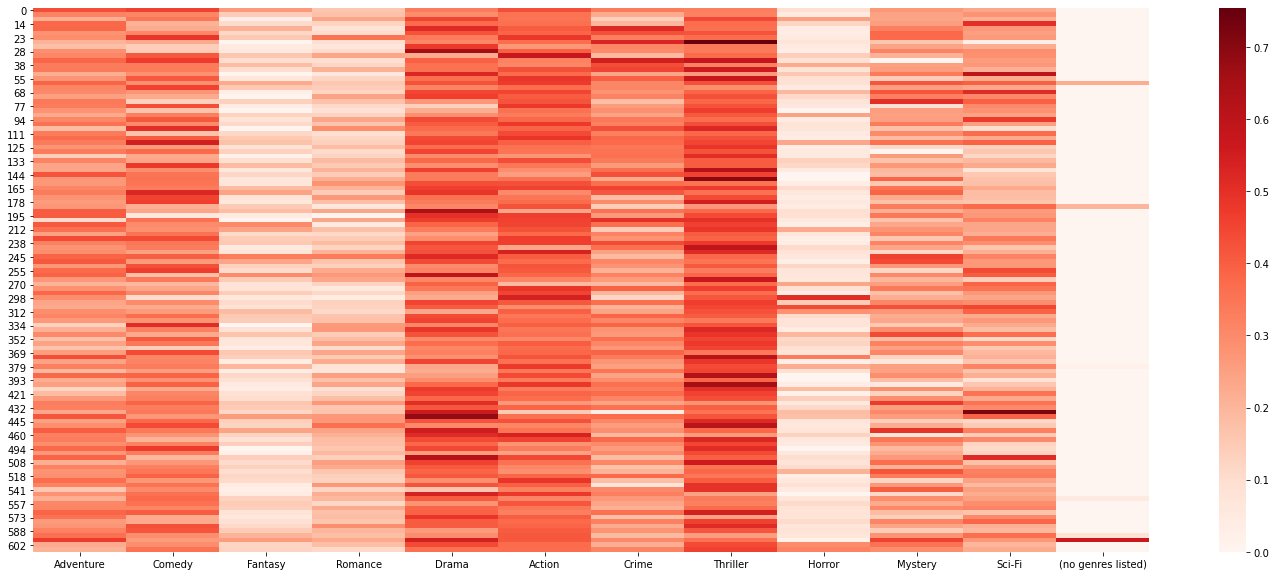

In [40]:
fig, ax1 = plt.subplots(figsize = (25, 10))
sns.heatmap(clust_df_scaled, ax = ax1, cmap = 'Reds')

In [41]:
clust_meanRatings = pd.pivot_table(clust_movieRatings, index='userId', columns= 'movieId', values='rating')
clust_meanRatings = clust_meanRatings.mean(axis = 0, skipna = True)
clust_meanRatings_df = pd.DataFrame({'movieId':clust_meanRatings.index, 'clusterRating':clust_meanRatings.values})

clust_movieRatings = pd.merge(clust_movieRatings, clust_meanRatings_df, on='movieId')
clust_movieRatings = clust_movieRatings.drop(['userId', 'rating', 'UserRatingCount'], axis=1)

In [42]:
clust_movieRatings['ClustMovieRatingCount'] = clust_movieRatings.groupby('movieId')['movieId'].transform('count')


In [45]:
clust_movieRatings = clust_movieRatings.drop_duplicates('movieId')
user_movie_ratings = pd.pivot_table(ratings, index='userId', columns= 'movieId', values='rating')
movie_mean_ratings = user_movie_ratings.mean(axis = 0, skipna = True)
mean_ratings_df = pd.DataFrame({'movieId':movie_mean_ratings.index, 'MovieMeanRating':movie_mean_ratings.values})

clust_movieRatings = pd.merge(clust_movieRatings, mean_ratings_df, on='movieId')
clust_movieRatings

,movieId,clusterRating,ClustMovieRatingCount,MovieMeanRating
0,1,4.058824,51,3.920930
1,3,3.666667,9,3.259615
2,6,4.090909,33,3.946078
3,47,4.241667,60,3.975369
4,50,4.361111,54,4.237745
...,...,...,...,...
1665,477,3.333333,3,3.382353
1666,532,3.125000,4,3.000000
1667,4054,2.666667,3,2.843750
1668,86,3.333333,3,3.966667


In [50]:
for i in clust_movieRatings['movieId'].values:
    print(movies_save.loc[movies_save['movieId'] == i]['title'])

257    Pulp Fiction (1994)
Name: title, dtype: object
277    Shawshank Redemption, The (1994)
Name: title, dtype: object
314    Forrest Gump (1994)
Name: title, dtype: object
510    Silence of the Lambs, The (1991)
Name: title, dtype: object
1939    Matrix, The (1999)
Name: title, dtype: object
97    Braveheart (1995)
Name: title, dtype: object
615    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object
507    Terminator 2: Judgment Day (1991)
Name: title, dtype: object
43    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object
418    Jurassic Park (1993)
Name: title, dtype: object
337    True Lies (1994)
Name: title, dtype: object
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object
509    Batman (1989)
Name: title, dtype: object
898    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object
31    Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Name: title, dtype: object
398    Fugitive, The (1993)
Name: title, dtype: object
46    Usu